# Add final layer and benchmark

In [16]:
from tensorflow.keras.models import load_model
import sys
print(sys.executable)
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os
from time import time
import pandas as pd
from glob import glob
from KerasOCRTrainer2 import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, optimizers
from tensorflow import keras
from tensorflow.keras.layers import Lambda
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import cv2
from PIL import Image
from random import shuffle

/Users/eduard/.pyenv/versions/3.6.8/envs/keras36/bin/python


# build dragon mini 16 48

In [2]:
im_size = 48
ks = 5

input_img = Input(shape=(im_size, im_size, 3))
conv1 = Conv2D(16, (ks, ks), strides=2, padding='same', activation='relu')(input_img)
drop1 = Dropout(0.05)(conv1)
conv2 = Conv2D(16, (ks, ks), strides=2, padding='same', activation='relu')(drop1)
drop2 = Dropout(0.05)(conv2)
flat1  = Flatten()(drop2)
num1 = Dense(11,activation='softmax',name='num1')(flat1)
num2 = Dense(11,activation='softmax',name='num2')(flat1)
num3 = Dense(11,activation='softmax',name='num3')(flat1)

model = Model(inputs = input_img, outputs=[num1,num2,num3])
model

W0820 13:38:21.542469 4576617920 deprecation.py:506] From /Users/eduard/.pyenv/versions/3.6.8/envs/keras36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [3]:
model.load_weights('models/ep50-va1.04.hdf5')

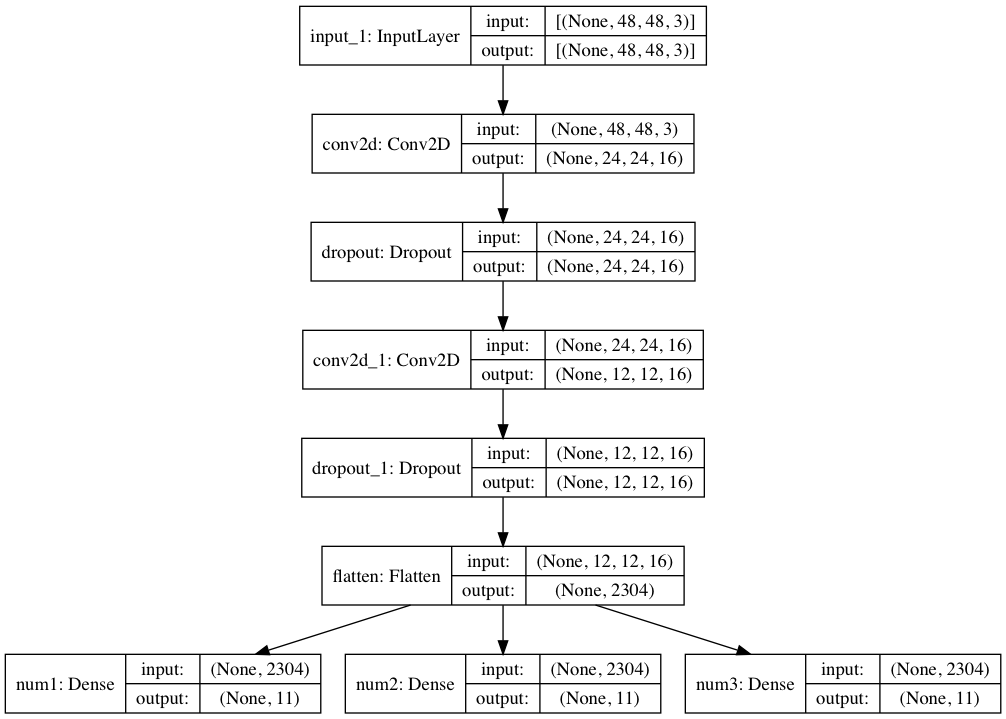

In [4]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

In [28]:
out = concatenate([num1,num2,num3],axis=1)
model2 = Model(inputs=input_img,outputs = out)
# model2.compile(optimizers.Adam(lr=0.001),loss="categorical_crossentropy")
# keras.utils.plot_model(model2, 'dragon_combined.png', show_shapes=True)
model2.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 16)   1216        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 24, 24, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 12, 16)   6416        dropout[0][0]                    
____________________________________________________________________________________________

In [6]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 16)   1216        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 24, 24, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 12, 16)   6416        dropout[0][0]                    
____________________________________________________________________________________________

In [7]:
file_list = glob('/Users/eduard/workspaces/ml_projects/keras/VitmoOCR/data2/*/*.png')
shuffle(file_list)
img = Image.open(file_list[0])
img2 = img.resize((48,48))
img2 = np.array(img2).reshape(1,48,48,3)

In [8]:
one_hot = model2.predict(img2)
one_hot = (one_hot.reshape(3,11)>0.5).astype(int)
one_hot

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [9]:
def get_image(file_path):
    img = Image.open(file_path)
    img = img.resize((48,48))
    img = np.array(img).reshape(1,48,48,3)
    return img

def reverse_one_hot(one_hot):
    categories = [' ','0','1','2','3','4','5','6','7','8','9']
    ix0 = one_hot[0].tolist().index(1)
    ix1 = one_hot[1].tolist().index(1)
    ix2 = one_hot[2].tolist().index(1)
    res = categories[ix0]+categories[ix1]+categories[ix2]
    return res

def predict_label(model, img):
    one_hot = model.predict(img)
    one_hot = (one_hot.reshape(3,11)>0.5).astype(int)
    res = reverse_one_hot(one_hot)
    return res
    
# reverse_one_hot(one_hot)

# Benchmark current model:

In [10]:
def benchmark_file_list(model, file_list):
    n_correct = 0
    n_incorrect = 0
    for ix, file in enumerate(file_list):
        label = file.split('/')[-2]
        label=label.rjust(3)
        img = get_image(file)
        res = predict_label(model,img)
        if res == label:
            n_correct = n_correct+1
        else:
            n_incorrect = n_incorrect+1
            #print(f'res:{res}, lab:{label}')
        acc = n_correct/(n_correct+n_incorrect)
        print(f'\r ix:{ix} accuracy: {acc}', end = '')    
    return acc
        
        
acc = benchmark_file_list(model2, file_list[:5000])

 ix:4999 accuracy: 0.7104421084216843

# Save recomposed model

In [11]:
model_name =     f'recombined_models/dragon_mini_16_48_{int(acc*100)}.h5'
tf_lite_model_name = f'tflite_models/dragon_mini_16_48_{int(acc*100)}.tflite'
model2.save(model_name)

In [12]:
# Convert to TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model_file(model_name)
tflite_model = converter.convert()
open(tf_lite_model_name, "wb").write(tflite_model)

W0820 13:38:40.455389 4576617920 deprecation.py:506] From /Users/eduard/.pyenv/versions/3.6.8/envs/keras36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0820 13:38:40.456538 4576617920 deprecation.py:506] From /Users/eduard/.pyenv/versions/3.6.8/envs/keras36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0820 13:38:40.631911 4576617920 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0820 

337236

# Benchmark TFLite model

In [19]:

interpreter = tf.compat.v2.lite.Interpreter(model_path=tflite_model)
# interpreter.allocate_tensors()
# # Get input and output tensors.
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()
# # Test model on random input data.
# input_shape = input_details[0]['shape']

# files = file_list[:1000]
# shuffle(files)
# incorrect_classes = []
# all_classes = []
# n_correct = 0
# n_incorrect = 0

# for ix, file in enumerate([files[0]]):

#     img = Image.open(file)
#     img = img.resize((48, 48))
#     np_img = np.array(img, dtype=np.float32).reshape(*input_shape)

#     img_mean = np.mean(np_img)
#     img_std = np.std(np_img)

#     np_img = np_img/255
#     interpreter.set_tensor(input_details[0]['index'], np_img)
#     interpreter.invoke()
#     output_data = interpreter.get_tensor(output_details[0]['index'])


NotImplementedError: Wrong number or type of arguments for overloaded function 'InterpreterWrapper_CreateWrapperCPPFromFile'.
  Possible C/C++ prototypes are:
    tflite::interpreter_wrapper::InterpreterWrapper::CreateWrapperCPPFromFile(char const *,std::string *)
    tflite::interpreter_wrapper::InterpreterWrapper::tflite_interpreter_wrapper_InterpreterWrapper_CreateWrapperCPPFromFile__SWIG_1(char const *)
